# Word2vec research

In this notebook we are going to build a text classifier which utilizes our own trained word2vec model.

Word2vec expects a list of sentences where each sentence is a list of words. 

So the input must be a list of lists.

Let's load up a few example sentences from the 20 newsgroups dataset.

In [1]:
import re
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian','comp.graphics','sci.med']

train_set = fetch_20newsgroups(subset='train',
                           categories=categories,
                           remove=('headers', 'footers', 'quotes'),
                           shuffle=True, 
                           random_state=42)

test_set = fetch_20newsgroups(subset='test',                          
                          categories=categories,
                          remove=('headers', 'footers', 'quotes'),
                          shuffle=True, 
                          random_state=42)

print("Train documents: %d"%(len(train_set.data)))
print("Test documents: %d"%(len(test_set.data)))

Train documents: 2257
Test documents: 1502


Prepare the sentences for Word2vec.

In [2]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]

all_data = train_set.data + test_set.data
sentences = [line for text in all_data for line in clean(text)]

print("Number of sentences: %d"%len(sentences))

Number of sentences: 56025


In [3]:
print("Example sentence:\n %s"%sentences[6])

Example sentence:
 ['hi', 'i', 'have', 'a', 'problem', 'i', 'hope', 'some', 'of', 'the', 'gurus', 'can', 'help', 'me', 'solve']


Now that we have our data in the expected format we define and train our model.

## Word2vec model

In [5]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, workers=4, size=100, 
                 min_count=55, window=10, sample=1e-3)

To save memory we are going to delete the model after training and we will keep only the word vectors and vocabulary.

In [6]:
wv = model.wv
voc = model[model.wv.vocab]
del model

We can verify that our model is train by looking for most similar words.

In [7]:
wv.most_similar('data')

[('tools', 0.9361498951911926),
 ('workstations', 0.9216489195823669),
 ('functions', 0.9181867241859436),
 ('map', 0.9159494638442993),
 ('applications', 0.9125773310661316),
 ('input', 0.9107691645622253),
 ('macintosh', 0.9098544716835022),
 ('digital', 0.9097176790237427),
 ('database', 0.9078805446624756),
 ('objects', 0.9076888561248779)]

## Using the model

Find the top-N most similar words. Positive words contribute positively towards the similarity, negative words negatively.

In [8]:
 wv.most_similar(positive=['program', 'data'], negative=['windows'])

[('type', 0.8257811069488525),
 ('database', 0.8244974613189697),
 ('processing', 0.8080503940582275),
 ('tools', 0.8070446252822876),
 ('set', 0.7962357997894287),
 ('package', 0.7956840991973877),
 ('conversion', 0.7931721806526184),
 ('analysis', 0.7930004596710205),
 ('full', 0.7779415249824524),
 ('library', 0.772416889667511)]

Similarity of 2 words.

In [9]:
wv.similarity('computer', 'software')

0.70607285076539439

In [10]:
wv.similarity('computer', 'human')

-0.10868000747574436

Let's visualize the data using t-SNE.

## t-SNE for visualizations

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique useful for visualization of high-dimensional data.

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Train the t-SNE model

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(voc)

Plot the values

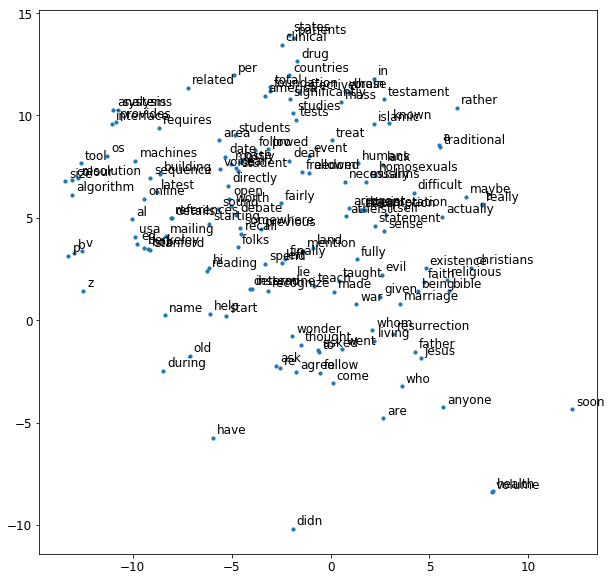

In [13]:
# number of values to plot
num_plot = 150

matplotlib.rcParams.update({'font.size': 12})

# detailed plotting function
def my_scatter_plot(scatter_data):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    plot_x = scatter_data[:num_plot, 0]
    plot_y = scatter_data[:num_plot, 1]
    ax.scatter(plot_x, plot_y, s=10)
    for i, txt in enumerate(list(wv.vocab.keys())[:num_plot]):
        ax.annotate(txt, (plot_x[i] + 0.2,plot_y[i] + 0.2))
        
my_scatter_plot(X_tsne)

## Truncated SVD

To improve the visualization it is helpful to perform dimensionality reduction with TruncatedSVD and then t-SNE.
Let's try that.

In [14]:
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(voc)

X_embedded = TSNE(n_components=2, perplexity=40).fit_transform(X_reduced)

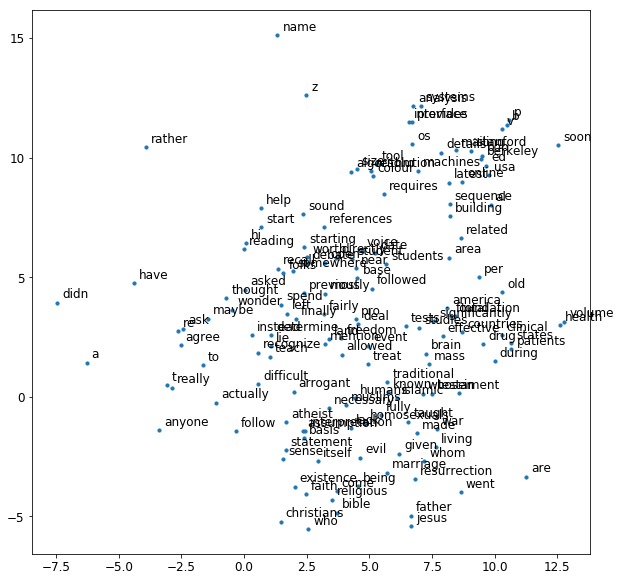

In [15]:
my_scatter_plot(X_embedded)

## Training a classifier based on Word2vec

### Word embedding

Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing (NLP) where words or phrases from the vocabulary are mapped to vectors of real numbers.

Define our own Vectorizer to use in a scikit-learn pipeline.

In [16]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

w2v = {w: vec for w, vec in zip(wv.index2word, wv.syn0)}

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

## Training data preparation

Our data must be prepared in the tokenized form.

In [17]:
import pandas as pd

def prepare_data(dataset):
    x_ds = []
    y_ds = []
    for i in range(len(dataset.data)):
        words = []
        for line in clean(dataset.data[i]):
            words.extend(line)
        x_ds.append(words)
        y_ds.append(dataset.target[i])
    return x_ds,y_ds

x_train, y_train = prepare_data(train_set)
x_test, y_test = prepare_data(test_set)

training_data = pd.DataFrame({
    'x_train': x_train,
    'y_train': y_train
})
training_data.head()

,x_train,y_train
0,"[does, anyone, know, of, a, good, way, standar...",1
1,"[hi, i, have, a, problem, i, hope, some, of, t...",1
2,"[well, i, ll, email, also, but, this, may, app...",3
3,"[hello, i, m, writing, a, paper, on, the, role...",3
4,[],3


## Training the classifier

Now we can train our model based on Linear SVM.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

text_clf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
                     ('clf', SVC(kernel="linear"))
])

text_clf.fit(x_train, y_train)
predicted = text_clf.predict(x_test)
print("Accuracy on the test set: %.2f%%" % 
      (np.mean(predicted == y_test) * 100))

Accuracy on the test set: 72.97%


Let's visualize the metics of the model.

In [19]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted,
    target_names=test_set.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.62      0.52      0.56       319
         comp.graphics       0.87      0.87      0.87       389
               sci.med       0.70      0.75      0.72       396
soc.religion.christian       0.70      0.74      0.72       398

           avg / total       0.73      0.73      0.73      1502



## Comparison with bag of words approach

In [20]:
from sklearn.svm import SVC

svc_tfidf = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), 
    ("linear svc", SVC(kernel="linear"))
])
svc_tfidf.fit(x_train, y_train)
predicted = svc_tfidf.predict(x_test)
print("Accuracy on the test set: %.2f%%" % 
      (np.mean(predicted == y_test) * 100))

Accuracy on the test set: 79.76%


In [21]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted,
    target_names=test_set.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.73      0.63      0.67       319
         comp.graphics       0.80      0.90      0.85       389
               sci.med       0.86      0.82      0.84       396
soc.religion.christian       0.78      0.81      0.79       398

           avg / total       0.80      0.80      0.80      1502



## TODO: Word2Vec model is worst than bag of words, why?